# 1. imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import torchmetrics
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# 2. function convert str of text to list when we upload data

In [2]:
def str_text_to_list(value):
    list_values = value.strip('[]').split(', ')
    cleaned_list_values = [item[1:-1] for item in list_values]
    return cleaned_list_values

# 3. take labels from data

In [3]:
dataset_wsd_1 = pd.read_csv("../datasets/tonetags_wsd_1.csv", index_col=0, converters={"text": str_text_to_list})

labels = dataset_wsd_1.tags.unique().tolist()

del dataset_wsd_1
gc.collect()

0

# 4. create vocab and embedding by some pretrained embedding

In [4]:
glove_6b_50 = torchtext.vocab.GloVe(name='6B', dim=50)

In [5]:
vocab = glove_6b_50.stoi
vocab["<unk>"] = len(vocab)
vocab["<pad>"] = len(vocab)

In [6]:
embedding_vector = glove_6b_50.vectors.numpy()
embedding_vector = np.append(embedding_vector, np.zeros(50)).reshape(-1, 50) # vector for unknown value in vocab
embedding_vector = np.append(embedding_vector, np.ones(50)).reshape(-1, 50) # vector for padding value in vocab

In [7]:
embedding_tensor = torch.tensor(embedding_vector, dtype=torch.float)

In [8]:
nn.Embedding.from_pretrained(embedding_tensor, freeze=True)

Embedding(400002, 50)

# 5. create class of datasets

In [9]:
max_length = 4096

In [10]:
class myDataset(Dataset):
    def __init__(self, dataset):
        self.data = []
        for sentence in dataset.text:
            if len(sentence) > max_length:
                continue
            sentence_ids = []
            for token in sentence:
                try:
                    sentence_ids.append(vocab[token])
                except KeyError:
                    sentence_ids.append(vocab["<unk>"])
            self.data.append(sentence_ids)
        self.labels = dataset.tags

        self.context = None

        if 'context' in dataset.columns:
            self.context = dataset.context

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.context is None:
            return self.data[idx], torch.tensor(self.labels.iloc[idx])
        else:
            return self.data[idx], torch.tensor(self.labels.iloc[idx]), self.context.iloc[idx]

# 6. Dataloader part

In [11]:
batch_size = 32

In [12]:
def collate_fn(batch):
    data_ids = []
    labels = []
    contexts = []

    for dat in batch:

        data_ids.append(dat[0])
        labels.append(dat[1])

        if len(dat) >= 3:
            contexts.append(dat[2])

    for i in range(len(data_ids)):
        while len(data_ids[i]) < max_length:
            data_ids[i].append(vocab["<pad>"])

    return torch.tensor(data_ids), torch.tensor(contexts), torch.tensor(labels)

# 7. Create model

## 7.1. lstm for wsd_1, clean and clean_corrected datasets

In [13]:
class ToneTagsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding, hidden_dim, output_size, num_layers, dropout):
        super(ToneTagsLSTM, self).__init__()
        # vocab_size = 400002
        # embedding_dim = 50
        # hidden_dim_lstm = 30
        
        # output_size = 19

        self.embedding = embedding

        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=dropout, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim * max_length * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_size)
        # self.out = nn.Softmax(output_size, dim=1)


    def forward(self, x):

        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)


        lstm_out = output.reshape(batch_size, -1)

        fc1_out = self.fc1(lstm_out)


        fc2_out = self.fc2(fc1_out)
        out = self.fc3(fc2_out)
        # out = self.out(fc3_out)

        return out

## 7.2. parameters of this model

In [14]:
vocab_size = len(vocab) # 4000002
embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
hidden_dim = 30 # 30
output_size = len(labels) # 19
num_layers = 4
dropout = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-4

n_epochs = 20


criterion = nn.CrossEntropyLoss()

# 8. accuracy function

In [15]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

# 9. wsd_1 dataset

## 9.1. upload dataset

In [16]:
dataset_wsd_1 = pd.read_csv("../datasets/tonetags_wsd_1.csv", index_col=0, converters={"text": str_text_to_list})

## 9.2. encode labels

In [17]:
dataset_wsd_1.tags = dataset_wsd_1.tags.apply(labels.index)

## 9.3. split

In [18]:
train_wsd_1, test_wsd_1 = train_test_split(dataset_wsd_1, stratify=dataset_wsd_1['tags'], test_size=0.2, random_state=42)

## 9.4. create datasets

In [19]:
train_dataset_wsd_1, test_dataset_wsd_1 = myDataset(train_wsd_1), myDataset(test_wsd_1)

## 9.5. create dataloaders

In [20]:
train_dataloader_wsd_1 = DataLoader(train_dataset_wsd_1, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

test_dataloader_wsd_1 = DataLoader(test_dataset_wsd_1, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

## 9.6. create instance of model and optimizer

In [21]:
# train_dataloader_wsd_1
# test_dataloader_wsd_1

model_wsd_1 = ToneTagsLSTM(
    vocab_size=vocab_size,
    embedding=embedding,
    hidden_dim=hidden_dim,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer_wsd_1 = optim.Adam(model_wsd_1.parameters(), lr=lr)

## 9.7. train and test model for wsd_1 dataloader

In [22]:
%%time

losses_train_wsd_1 = []
accuracies_train_wsd_1 = []

losses_test_wsd_1 = []
accuracies_test_wsd_1 = []

for ep in range(1, n_epochs + 1):

    model_wsd_1.train()
    epoch_losses_train = []
    epoch_accuracies_train = []


    for tokens, contexts, tags in tqdm(train_dataloader_wsd_1, desc="training..."):
        optimizer_wsd_1.zero_grad()

        tokens = tokens.to(device)
        tags = tags.to(device)

        predictions = model_wsd_1(tokens)

        loss = criterion(predictions, tags)
        accuracy = get_accuracy(predictions, tags)

        loss.backward()
        optimizer_wsd_1.step()

        epoch_losses_train.append(loss.item())
        epoch_accuracies_train.append(accuracy.item())

    del tokens
    del tags
    
    gc.collect()
    torch.cuda.empty_cache()

    losses_train_wsd_1.append(np.mean(epoch_losses_train))
    accuracies_train_wsd_1.append(np.mean(epoch_accuracies_train))
    
    print(f'[Train Epoch {ep}] Loss: {np.mean(epoch_losses_train)}, Accuracy: {np.mean(epoch_accuracies_train)}')


    model_wsd_1.eval()
    epoch_losses_test = []
    epoch_accuracies_test = []

    with torch.no_grad():
        for tokens, contexts, tags in tqdm(test_dataloader_wsd_1, desc="testing..."):
            tokens = tokens.to(device)
            tags = tags.to(device)

            predictions = model_wsd_1(tokens)

            loss = criterion(predictions, tags)
            accuracy = get_accuracy(predictions, tags)

            epoch_losses_test.append(loss.item())
            epoch_accuracies_test.append(accuracy.item())

        del tokens
        del tags
    
        gc.collect()
        torch.cuda.empty_cache()

        losses_test_wsd_1.append(np.mean(epoch_losses_test))
        accuracies_test_wsd_1.append(np.mean(epoch_accuracies_test))
        
        print(f'[Test Epoch {ep}] Loss: {np.mean(epoch_losses_test)}, Accuracy: {np.mean(epoch_accuracies_test)}\n')

training...: 100%|██████████| 2113/2113 [06:06<00:00,  5.76it/s]


[Train Epoch 1] Loss: 2.913261704912019, Accuracy: 0.15722610033128254


testing...: 100%|██████████| 528/528 [00:34<00:00, 15.37it/s]


[Test Epoch 1] Loss: 2.660635395483537, Accuracy: 0.16915246212121213


training...: 100%|██████████| 2113/2113 [05:51<00:00,  6.01it/s]


[Train Epoch 2] Loss: 2.6689528331224013, Accuracy: 0.16465037860861334


testing...: 100%|██████████| 528/528 [00:27<00:00, 19.26it/s]


[Test Epoch 2] Loss: 2.657520623821201, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [05:55<00:00,  5.95it/s]


[Train Epoch 3] Loss: 2.6645597944426638, Accuracy: 0.16769699479413155


testing...: 100%|██████████| 528/528 [00:27<00:00, 19.06it/s]


[Test Epoch 3] Loss: 2.6610316087802253, Accuracy: 0.1689157196969697


training...: 100%|██████████| 2113/2113 [05:57<00:00,  5.91it/s]


[Train Epoch 4] Loss: 2.6589075664857864, Accuracy: 0.1685695693327023


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.85it/s]


[Test Epoch 4] Loss: 2.6568025905977595, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [06:00<00:00,  5.86it/s]


[Train Epoch 5] Loss: 2.6569144759649808, Accuracy: 0.16879141031708472


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.73it/s]


[Test Epoch 5] Loss: 2.655668235637925, Accuracy: 0.1690340909090909


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.81it/s]


[Train Epoch 6] Loss: 2.6564796513649056, Accuracy: 0.16885056791292002


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.77it/s]


[Test Epoch 6] Loss: 2.6550624068036224, Accuracy: 0.1690340909090909


training...: 100%|██████████| 2113/2113 [06:04<00:00,  5.79it/s]


[Train Epoch 7] Loss: 2.656090522004257, Accuracy: 0.16885056791292002


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.81it/s]


[Test Epoch 7] Loss: 2.6556961260961764, Accuracy: 0.1689749053030303


training...: 100%|██████████| 2113/2113 [06:05<00:00,  5.78it/s]


[Train Epoch 8] Loss: 2.6558653516223294, Accuracy: 0.16885056791292002


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.64it/s]


[Test Epoch 8] Loss: 2.655858191576871, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [06:04<00:00,  5.79it/s]


[Train Epoch 9] Loss: 2.6558013263608515, Accuracy: 0.16882098911500237


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.57it/s]


[Test Epoch 9] Loss: 2.6546322920105676, Accuracy: 0.1690340909090909


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.81it/s]


[Train Epoch 10] Loss: 2.6556951629568264, Accuracy: 0.1686730951254141


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.80it/s]


[Test Epoch 10] Loss: 2.6556819889581567, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.82it/s]


[Train Epoch 11] Loss: 2.6556015043985317, Accuracy: 0.16886535731187885


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.52it/s]


[Test Epoch 11] Loss: 2.654790259671934, Accuracy: 0.1690340909090909


training...: 100%|██████████| 2113/2113 [06:04<00:00,  5.80it/s]


[Train Epoch 12] Loss: 2.6556154660460964, Accuracy: 0.1688357785139612


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.73it/s]


[Test Epoch 12] Loss: 2.65681435845115, Accuracy: 0.1689749053030303


training...: 100%|██████████| 2113/2113 [06:05<00:00,  5.78it/s]


[Train Epoch 13] Loss: 2.655526649427256, Accuracy: 0.1688357785139612


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.69it/s]


[Test Epoch 13] Loss: 2.65469197296735, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [06:02<00:00,  5.83it/s]


[Train Epoch 14] Loss: 2.655625357539858, Accuracy: 0.16886535731187885


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.59it/s]


[Test Epoch 14] Loss: 2.654523374456348, Accuracy: 0.1689157196969697


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.81it/s]


[Train Epoch 15] Loss: 2.6550873081886084, Accuracy: 0.16888014671083768


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.59it/s]


[Test Epoch 15] Loss: 2.6550651969331684, Accuracy: 0.16909327651515152


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.82it/s]


[Train Epoch 16] Loss: 2.6554424652148354, Accuracy: 0.1688357785139612


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.58it/s]


[Test Epoch 16] Loss: 2.6552539973547966, Accuracy: 0.1689749053030303


training...: 100%|██████████| 2113/2113 [06:04<00:00,  5.80it/s]


[Train Epoch 17] Loss: 2.6555573518277344, Accuracy: 0.16879141031708472


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.51it/s]


[Test Epoch 17] Loss: 2.654757516402187, Accuracy: 0.1689749053030303


training...: 100%|██████████| 2113/2113 [06:03<00:00,  5.81it/s]


[Train Epoch 18] Loss: 2.6553002572770485, Accuracy: 0.16885056791292002


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.46it/s]


[Test Epoch 18] Loss: 2.654193636142846, Accuracy: 0.1689749053030303


training...: 100%|██████████| 2113/2113 [06:05<00:00,  5.79it/s]


[Train Epoch 19] Loss: 2.6552882210315825, Accuracy: 0.16886535731187885


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.66it/s]


[Test Epoch 19] Loss: 2.6545120346726794, Accuracy: 0.1688565340909091


training...: 100%|██████████| 2113/2113 [06:02<00:00,  5.83it/s]


[Train Epoch 20] Loss: 2.655223280572237, Accuracy: 0.1688949361097965


testing...: 100%|██████████| 528/528 [00:28<00:00, 18.67it/s]


[Test Epoch 20] Loss: 2.6550082781098108, Accuracy: 0.16909327651515152

CPU times: total: 2h 11min 23s
Wall time: 2h 11min 15s


## 9.8. delete some data

In [23]:
del train_dataloader_wsd_1
del test_dataloader_wsd_1
del train_dataset_wsd_1
del test_dataset_wsd_1
del train_wsd_1
del test_wsd_1
del dataset_wsd_1

del model_wsd_1
del optimizer_wsd_1
gc.collect()
torch.cuda.empty_cache()

# 10. clean dataset

## 10.1. upload dataset

In [24]:
dataset_clean = pd.read_csv("../datasets/tonetags_dataset_tumblr_clean.csv", converters={"text": str_text_to_list})

## 10.2. encode labels

In [25]:
dataset_clean.tags = dataset_clean.tags.apply(labels.index)

## 10.3. split

In [26]:
train_clean, test_clean = train_test_split(dataset_clean, stratify=dataset_clean['tags'], test_size=0.2, random_state=42)

## 10.4. create datasets

In [27]:
train_dataset_clean, test_dataset_clean = myDataset(train_clean), myDataset(test_clean)

## 10.5. create dataloaders

In [28]:
train_dataloader_clean = DataLoader(train_dataset_clean, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

test_dataloader_clean = DataLoader(test_dataset_clean, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

## 10.6. create instance of model and optimizer for clean dataloader

In [29]:
# train_dataloader_clean
# test_dataloader_clean

model_clean = ToneTagsLSTM(
    vocab_size=vocab_size,
    embedding=embedding,
    hidden_dim=hidden_dim,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer_clean = optim.Adam(model_clean.parameters(), lr=lr)

## 10.7. train and test model of clean dataloader

In [30]:
%%time

losses_train_clean = []
accuracies_train_clean = []

losses_test_clean = []
accuracies_test_clean = []

for ep in range(1, n_epochs + 1):

    model_clean.train()
    epoch_losses_train = []
    epoch_accuracies_train = []


    for tokens, contexts, tags in tqdm(train_dataloader_clean, desc="training..."):
        optimizer_clean.zero_grad()

        tokens = tokens.to(device)
        tags = tags.to(device)

        predictions = model_clean(tokens)

        loss = criterion(predictions, tags)
        accuracy = get_accuracy(predictions, tags)

        loss.backward()
        optimizer_clean.step()

        epoch_losses_train.append(loss.item())
        epoch_accuracies_train.append(accuracy.item())

    del tokens
    del tags

    gc.collect()
    torch.cuda.empty_cache()

    losses_train_clean.append(np.mean(epoch_losses_train))
    accuracies_train_clean.append(np.mean(epoch_accuracies_train))

    print(f'[Train Epoch {ep}] Loss: {np.mean(epoch_losses_train)}, Accuracy: {np.mean(epoch_accuracies_train)}')


    model_clean.eval()
    epoch_losses_test = []
    epoch_accuracies_test = []

    with torch.no_grad():
        for tokens, contexts, tags in tqdm(test_dataloader_clean, desc="testing..."):

            tokens = tokens.to(device)
            tags = tags.to(device)

            predictions = model_clean(tokens)

            loss = criterion(predictions, tags)
            accuracy = get_accuracy(predictions, tags)

            epoch_losses_test.append(loss.item())
            epoch_accuracies_test.append(accuracy.item())

        del tokens
        del tags
    
        gc.collect()
        torch.cuda.empty_cache()

        losses_test_clean.append(np.mean(epoch_losses_test))
        accuracies_test_clean.append(np.mean(epoch_accuracies_test))

        print(f'[Test Epoch {ep}] Loss: {np.mean(epoch_losses_test)}, Accuracy: {np.mean(epoch_accuracies_test)}\n')

training...: 100%|██████████| 2131/2131 [06:36<00:00,  5.37it/s]


[Train Epoch 1] Loss: 2.8315150484911213, Accuracy: 0.15937353355232287


testing...: 100%|██████████| 532/532 [00:35<00:00, 15.05it/s]


[Test Epoch 1] Loss: 2.660612985155636, Accuracy: 0.16882048872180452


training...: 100%|██████████| 2131/2131 [06:02<00:00,  5.88it/s]


[Train Epoch 2] Loss: 2.6695288607124317, Accuracy: 0.16460875175973722


testing...: 100%|██████████| 532/532 [00:27<00:00, 19.14it/s]


[Test Epoch 2] Loss: 2.6559410319292454, Accuracy: 0.16876174812030076


training...: 100%|██████████| 2131/2131 [06:02<00:00,  5.88it/s]


[Train Epoch 3] Loss: 2.6626768561944556, Accuracy: 0.16688174565931488


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.99it/s]


[Test Epoch 3] Loss: 2.6562303672159526, Accuracy: 0.1689967105263158


training...: 100%|██████████| 2131/2131 [06:05<00:00,  5.83it/s]


[Train Epoch 4] Loss: 2.6579822135721223, Accuracy: 0.1687441342092914


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.63it/s]


[Test Epoch 4] Loss: 2.6556190776645687, Accuracy: 0.16887922932330826


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.82it/s]


[Train Epoch 5] Loss: 2.6568248095170035, Accuracy: 0.168700140778977


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.69it/s]


[Test Epoch 5] Loss: 2.6552143943937203, Accuracy: 0.168703007518797


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 6] Loss: 2.656622636155979, Accuracy: 0.16867081182543406


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.60it/s]


[Test Epoch 6] Loss: 2.654723636189798, Accuracy: 0.16887922932330826


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 7] Loss: 2.656135870894598, Accuracy: 0.168700140778977


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.84it/s]


[Test Epoch 7] Loss: 2.6611015339543047, Accuracy: 0.16876174812030076


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 8] Loss: 2.655995133112205, Accuracy: 0.168700140778977


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.64it/s]


[Test Epoch 8] Loss: 2.6557001296738934, Accuracy: 0.16876174812030076


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 9] Loss: 2.656120442381939, Accuracy: 0.1687441342092914


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.62it/s]


[Test Epoch 9] Loss: 2.6554055021221474, Accuracy: 0.16882048872180452


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.82it/s]


[Train Epoch 10] Loss: 2.655841737999596, Accuracy: 0.16868547630220554


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.66it/s]


[Test Epoch 10] Loss: 2.6551921013602637, Accuracy: 0.16893796992481203


training...: 100%|██████████| 2131/2131 [06:07<00:00,  5.80it/s]


[Train Epoch 11] Loss: 2.656083968031412, Accuracy: 0.16849483810417645


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.67it/s]


[Test Epoch 11] Loss: 2.6547276655534158, Accuracy: 0.16882048872180452


training...: 100%|██████████| 2131/2131 [06:05<00:00,  5.84it/s]


[Train Epoch 12] Loss: 2.6557643800652233, Accuracy: 0.168700140778977


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.77it/s]


[Test Epoch 12] Loss: 2.655550176935985, Accuracy: 0.16876174812030076


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 13] Loss: 2.655688178086158, Accuracy: 0.16871480525574847


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.57it/s]


[Test Epoch 13] Loss: 2.654464508805956, Accuracy: 0.168703007518797


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.82it/s]


[Train Epoch 14] Loss: 2.655777979434124, Accuracy: 0.1686561473486626


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.47it/s]


[Test Epoch 14] Loss: 2.654597048024486, Accuracy: 0.16893796992481203


training...: 100%|██████████| 2131/2131 [06:10<00:00,  5.75it/s]


[Train Epoch 15] Loss: 2.6555955658379657, Accuracy: 0.16872946973251995


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.53it/s]


[Test Epoch 15] Loss: 2.6542045218603953, Accuracy: 0.16905545112781956


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 16] Loss: 2.6554840122349996, Accuracy: 0.16868547630220554


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.57it/s]


[Test Epoch 16] Loss: 2.6554340733621355, Accuracy: 0.16893796992481203


training...: 100%|██████████| 2131/2131 [06:10<00:00,  5.75it/s]


[Train Epoch 17] Loss: 2.6555084804031894, Accuracy: 0.16868547630220554


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.51it/s]


[Test Epoch 17] Loss: 2.655212239663404, Accuracy: 0.16876174812030076


training...: 100%|██████████| 2131/2131 [06:07<00:00,  5.80it/s]


[Train Epoch 18] Loss: 2.6554088556727353, Accuracy: 0.1686561473486626


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.50it/s]


[Test Epoch 18] Loss: 2.655583784096223, Accuracy: 0.168703007518797


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.82it/s]


[Train Epoch 19] Loss: 2.655613036404077, Accuracy: 0.168700140778977


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.42it/s]


[Test Epoch 19] Loss: 2.6543842751280704, Accuracy: 0.1689967105263158


training...: 100%|██████████| 2131/2131 [06:06<00:00,  5.81it/s]


[Train Epoch 20] Loss: 2.655440668162467, Accuracy: 0.16868547630220554


testing...: 100%|██████████| 532/532 [00:28<00:00, 18.51it/s]


[Test Epoch 20] Loss: 2.6552534766663287, Accuracy: 0.168703007518797

CPU times: total: 2h 13min 13s
Wall time: 2h 13min 3s


## 10.8. delete some data

In [31]:
del train_dataloader_clean
del test_dataloader_clean
del train_dataset_clean
del test_dataset_clean
del train_clean
del test_clean
del dataset_clean

del model_clean
del optimizer_clean
gc.collect()
torch.cuda.empty_cache()

# 11. clean_corrected dataset

## 11.1. upload dataset

In [32]:
dataset_clean_corrected = pd.read_csv("../datasets/tonetags_dataset_tumblr_clean_corrected_text.csv", converters={"text": str_text_to_list})

## 11.2. encode labels

In [33]:
dataset_clean_corrected.tags =dataset_clean_corrected.tags.apply(labels.index)

## 11.3. split

In [34]:
train_clean_corrected, test_clean_corrected = train_test_split(dataset_clean_corrected, stratify=dataset_clean_corrected['tags'], test_size=0.2, random_state=42)

## 11.4. create datasets

In [35]:
train_dataset_clean_corrected, test_dataset_clean_corrected = myDataset(train_clean_corrected), myDataset(test_clean_corrected)

## 11.5. create dataloaders

In [36]:
train_dataloader_clean_corrected = DataLoader(train_dataset_clean_corrected, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

test_dataloader_clean_corrected = DataLoader(test_dataset_clean_corrected, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

## 11.6. create instance of model and optimizer for clean_corrected data

In [37]:
# train_dataloader_clean_corrected
# test_dataloader_clean_corrected

model_clean_corrected = ToneTagsLSTM(
    vocab_size=vocab_size,
    embedding=embedding,
    hidden_dim=hidden_dim,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer_clean_corrected = optim.Adam(model_clean_corrected.parameters(), lr=lr)

## 11.7. train and test for clean_corrected dataloader

In [38]:
%%time

losses_train_clean_corrected = []
accuracies_train_clean_corrected = []

losses_test_clean_corrected = []
accuracies_test_clean_corrected = []

for ep in range(1, n_epochs + 1):

    model_clean_corrected.train()
    epoch_losses_train = []
    epoch_accuracies_train = []


    for tokens, contexts, tags in tqdm(train_dataloader_clean_corrected, desc="training..."):
        optimizer_clean_corrected.zero_grad()

        tokens = tokens.to(device)
        tags = tags.to(device)

        predictions = model_clean_corrected(tokens)

        loss = criterion(predictions, tags)
        accuracy = get_accuracy(predictions, tags)

        loss.backward()
        optimizer_clean_corrected.step()

        epoch_losses_train.append(loss.item())
        epoch_accuracies_train.append(accuracy.item())

    del tokens
    del tags

    gc.collect()
    torch.cuda.empty_cache()

    losses_train_clean_corrected.append(np.mean(epoch_losses_train))
    accuracies_train_clean_corrected.append(np.mean(epoch_accuracies_train))

    print(f'[Train Epoch {ep}] Loss: {np.mean(epoch_losses_train)}, Accuracy: {np.mean(epoch_accuracies_train)}')


    model_clean_corrected.eval()
    epoch_losses_test = []
    epoch_accuracies_test = []

    with torch.no_grad():
        for tokens, contexts, tags in tqdm(test_dataloader_clean_corrected, desc="testing..."):

            tokens = tokens.to(device)
            tags = tags.to(device)

            predictions = model_clean_corrected(tokens)

            loss = criterion(predictions, tags)
            accuracy = get_accuracy(predictions, tags)

            epoch_losses_test.append(loss.item())
            epoch_accuracies_test.append(accuracy.item())

        del tokens
        del tags
    
        gc.collect()
        torch.cuda.empty_cache()

        losses_test_clean_corrected.append(np.mean(epoch_losses_test))
        accuracies_test_clean_corrected.append(np.mean(epoch_accuracies_test))

        print(f'[Test Epoch {ep}] Loss: {np.mean(epoch_losses_test)}, Accuracy: {np.mean(epoch_accuracies_test)}\n')

training...: 100%|██████████| 2127/2127 [06:33<00:00,  5.41it/s]


[Train Epoch 1] Loss: 2.867332976919191, Accuracy: 0.15996708979783733


testing...: 100%|██████████| 531/531 [00:33<00:00, 15.66it/s]


[Test Epoch 1] Loss: 2.6920747334898754, Accuracy: 0.1686087570621469


training...: 100%|██████████| 2127/2127 [05:59<00:00,  5.92it/s]


[Train Epoch 2] Loss: 2.669497440160582, Accuracy: 0.16475669957686884


testing...: 100%|██████████| 531/531 [00:27<00:00, 19.27it/s]


[Test Epoch 2] Loss: 2.660750300197278, Accuracy: 0.16854990583804144


training...: 100%|██████████| 2127/2127 [05:57<00:00,  5.96it/s]


[Train Epoch 3] Loss: 2.6635161996392167, Accuracy: 0.16653443817583452


testing...: 100%|██████████| 531/531 [00:27<00:00, 19.26it/s]


[Test Epoch 3] Loss: 2.6698927551564076, Accuracy: 0.1686087570621469


training...: 100%|██████████| 2127/2127 [06:00<00:00,  5.90it/s]


[Train Epoch 4] Loss: 2.6588087775755445, Accuracy: 0.16845909732016925


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.96it/s]


[Test Epoch 4] Loss: 2.6588526611723244, Accuracy: 0.1687264595103578


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.83it/s]


[Train Epoch 5] Loss: 2.656979988705232, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.72it/s]


[Test Epoch 5] Loss: 2.6561095094950185, Accuracy: 0.1687853107344633


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 6] Loss: 2.656262342617105, Accuracy: 0.16865009402914904


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.37it/s]


[Test Epoch 6] Loss: 2.659278284582939, Accuracy: 0.16849105461393596


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 7] Loss: 2.6562484662522716, Accuracy: 0.16865009402914904


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.76it/s]


[Test Epoch 7] Loss: 2.6555182174998713, Accuracy: 0.1686087570621469


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 8] Loss: 2.656013451106794, Accuracy: 0.16865009402914904


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.67it/s]


[Test Epoch 8] Loss: 2.6606971957140275, Accuracy: 0.16849105461393596


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.82it/s]


[Train Epoch 9] Loss: 2.6557941213705534, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.66it/s]


[Test Epoch 9] Loss: 2.6546868806504933, Accuracy: 0.16866760828625235


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 10] Loss: 2.6556092240073954, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.80it/s]


[Test Epoch 10] Loss: 2.6555680797598455, Accuracy: 0.16866760828625235


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.81it/s]


[Train Epoch 11] Loss: 2.6558096905409254, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.85it/s]


[Test Epoch 11] Loss: 2.655644368766167, Accuracy: 0.1684322033898305


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.82it/s]


[Train Epoch 12] Loss: 2.6554717460483466, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.71it/s]


[Test Epoch 12] Loss: 2.6554735528547213, Accuracy: 0.1684322033898305


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.81it/s]


[Train Epoch 13] Loss: 2.6555037704722446, Accuracy: 0.16865009402914904


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.57it/s]


[Test Epoch 13] Loss: 2.654139587434672, Accuracy: 0.1687264595103578


training...: 100%|██████████| 2127/2127 [06:10<00:00,  5.75it/s]


[Train Epoch 14] Loss: 2.6556086518924786, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.78it/s]


[Test Epoch 14] Loss: 2.6547022058914385, Accuracy: 0.16866760828625235


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.82it/s]


[Train Epoch 15] Loss: 2.6554391951307648, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.52it/s]


[Test Epoch 15] Loss: 2.657083814427004, Accuracy: 0.16866760828625235


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.82it/s]


[Train Epoch 16] Loss: 2.6554566865579368, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.57it/s]


[Test Epoch 16] Loss: 2.65433667384074, Accuracy: 0.1686087570621469


training...: 100%|██████████| 2127/2127 [06:05<00:00,  5.82it/s]


[Train Epoch 17] Loss: 2.655362123158486, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.55it/s]


[Test Epoch 17] Loss: 2.654036956991853, Accuracy: 0.1687853107344633


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 18] Loss: 2.6551673609604003, Accuracy: 0.16863540197461213


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.51it/s]


[Test Epoch 18] Loss: 2.6552834358143493, Accuracy: 0.1687264595103578


training...: 100%|██████████| 2127/2127 [06:04<00:00,  5.83it/s]


[Train Epoch 19] Loss: 2.6551536520602395, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.61it/s]


[Test Epoch 19] Loss: 2.655793872032237, Accuracy: 0.1687264595103578


training...: 100%|██████████| 2127/2127 [06:02<00:00,  5.86it/s]


[Train Epoch 20] Loss: 2.655194757799616, Accuracy: 0.16866478608368593


testing...: 100%|██████████| 531/531 [00:28<00:00, 18.63it/s]


[Test Epoch 20] Loss: 2.6581589443759954, Accuracy: 0.16866760828625235

CPU times: total: 2h 12min 27s
Wall time: 2h 12min 14s


## 11.8. delete some data

In [39]:
del train_dataloader_clean_corrected
del test_dataloader_clean_corrected
del train_dataset_clean_corrected
del test_dataset_clean_corrected
del train_clean_corrected
del test_clean_corrected
del dataset_clean_corrected

del model_clean_corrected
del optimizer_clean_corrected
gc.collect()
torch.cuda.empty_cache()

# 12. wsd_2 dataset

## 12.1. function to convert str of context to list when we upload dataset 

In [40]:
def str_context_to_list(value):
    list_values = value.strip('[]').split(' ')
    cleaned_list_values = []
    for item in list_values:
        item.strip()
        # if '\n' in item:
        #     item.replace('\n', '')
        if item != "":
            cleaned_list_values.append(float(item))
    return cleaned_list_values

## 12.2. upload dataset

In [41]:
# dataset_wsd_2 = pd.read_csv("../datasets/tonetags_wsd_2.csv", index_col=0, converters={"text": str_text_to_list, 'context': str_context_to_list})
dataset_wsd_2 = pd.read_csv("../datasets/tonetags_wsd_2.csv", index_col=0, converters={"text": str_text_to_list})

In [42]:
dataset_wsd_2 = dataset_wsd_2.dropna()

In [43]:
dataset_wsd_2.context = dataset_wsd_2.context.apply(str_context_to_list)

## 12.3. encode labels

In [44]:
dataset_wsd_2.tags = dataset_wsd_2.tags.apply(labels.index)

## 12.4. split

In [45]:
train_wsd_2, test_wsd_2 = train_test_split(dataset_wsd_2, stratify=dataset_wsd_2['tags'], test_size=0.2, random_state=42)

## 12.5. create datasets

In [46]:
train_dataset_wsd_2, test_dataset_wsd_2 = myDataset(train_wsd_2), myDataset(test_wsd_2)

## 12.6. create dataloaders

In [47]:
train_dataloader_wsd_2 = DataLoader(train_dataset_wsd_2, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

test_dataloader_wsd_2 = DataLoader(test_dataset_wsd_2, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)

## 12.7. class of model for wsd_2 data

In [48]:
class ToneTagsLSTM_wsd_2(nn.Module):
    def __init__(self, vocab_size, embedding, hidden_dim, context_dim, output_size, num_layers, dropout):
        super(ToneTagsLSTM_wsd_2, self).__init__()
        # vocab_size = 400002
        # embedding_dim = 50
        # hidden_dim_lstm = 30
        # context_dim = 50
        
        # output_size = 19

        self.embedding = embedding

        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=dropout, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim * max_length * 2 + context_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_size)
        # self.out = nn.Softmax(output_size, dim=1)


    def forward(self, tokens, contexts):

        embedded = self.embedding(tokens)
        output, (hidden, cell) = self.lstm(embedded)

        lstm_out = torch.cat((output.reshape(batch_size, -1), contexts), dim=1)

        fc1_out = self.fc1(lstm_out)


        fc2_out = self.fc2(fc1_out)
        out = self.fc3(fc2_out)
        # out = self.out(fc3_out)

        return out

## 12.8. parameters for wsd_2

In [49]:
# train_dataloader_wsd_2
# test_dataloader_wsd_2

vocab_size = len(vocab) # 4000002
embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
hidden_dim = 30 # 30
context_dim = 50 # 50
output_size = len(labels) # 19
num_layers = 4
dropout = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 5e-4

criterion = nn.CrossEntropyLoss()

## 12.9. create instance of model and optimizer to wsd_2 data

In [50]:
# train_dataloader_wsd_2
# test_dataloader_wsd_2

model_wsd_2 = ToneTagsLSTM_wsd_2(
    vocab_size=vocab_size,
    embedding=embedding,
    hidden_dim=hidden_dim,
    context_dim=context_dim,
    output_size=output_size,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer_wsd_2 = optim.Adam(model_wsd_2.parameters(), lr=lr)

## 12.10. train and test to wsd_2

In [51]:
%%time

losses_train_wsd_2 = []
accuracies_train_wsd_2 = []

losses_test_wsd_2 = []
accuracies_test_wsd_2 = []

for ep in range(1, n_epochs + 1):

    model_wsd_2.train()
    epoch_losses_train = []
    epoch_accuracies_train = []


    for tokens, contexts, tags in tqdm(train_dataloader_wsd_2, desc="training..."):
        optimizer_wsd_2.zero_grad()

        tokens = tokens.to(device)
        contexts = contexts.to(device)
        tags = tags.to(device)

        predictions = model_wsd_2(tokens, contexts)

        loss = criterion(predictions, tags)
        accuracy = get_accuracy(predictions, tags)

        loss.backward()
        optimizer_wsd_2.step()

        epoch_losses_train.append(loss.item())
        epoch_accuracies_train.append(accuracy.item())

    del tokens
    del contexts
    del tags

    gc.collect()
    torch.cuda.empty_cache()

    losses_train_wsd_2.append(np.mean(epoch_losses_train))
    accuracies_train_wsd_2.append(np.mean(epoch_accuracies_train))

    print(f'[Train Epoch {ep}] Loss: {np.mean(epoch_losses_train)}, Accuracy: {np.mean(epoch_accuracies_train)}')


    model_wsd_2.eval()
    epoch_losses_test = []
    epoch_accuracies_test = []

    with torch.no_grad():
        for tokens, contexts, tags in tqdm(test_dataloader_wsd_2, desc="testing..."):

            tokens = tokens.to(device)
            contexts = contexts.to(device)
            tags = tags.to(device)

            predictions = model_wsd_2(tokens, contexts)

            loss = criterion(predictions, tags)
            accuracy = get_accuracy(predictions, tags)

            epoch_losses_test.append(loss.item())
            epoch_accuracies_test.append(accuracy.item())

        del tokens
        del contexts
        del tags
    
        gc.collect()
        torch.cuda.empty_cache()


        losses_test_wsd_2.append(np.mean(epoch_losses_test))
        accuracies_test_wsd_2.append(np.mean(epoch_accuracies_test))

        print(f'[Test Epoch {ep}] Loss: {np.mean(epoch_losses_test)}, Accuracy: {np.mean(epoch_accuracies_test)}\n')

training...: 100%|██████████| 2088/2088 [06:22<00:00,  5.46it/s]


[Train Epoch 1] Loss: 2.7729311896580846, Accuracy: 0.21286817528735633


testing...: 100%|██████████| 521/521 [00:33<00:00, 15.40it/s]


[Test Epoch 1] Loss: 2.5304856908984927, Accuracy: 0.24676103646833014


training...: 100%|██████████| 2088/2088 [05:53<00:00,  5.90it/s]


[Train Epoch 2] Loss: 2.510059374045595, Accuracy: 0.25396611590038315


testing...: 100%|██████████| 521/521 [00:27<00:00, 18.89it/s]


[Test Epoch 2] Loss: 2.5006420145565627, Accuracy: 0.2635556621880998


training...: 100%|██████████| 2088/2088 [05:57<00:00,  5.84it/s]


[Train Epoch 3] Loss: 2.4782175702610236, Accuracy: 0.26861829501915707


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.29it/s]


[Test Epoch 3] Loss: 2.491744541160891, Accuracy: 0.26643474088291746


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.80it/s]


[Train Epoch 4] Loss: 2.46720535105444, Accuracy: 0.2740810584291188


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.29it/s]


[Test Epoch 4] Loss: 2.4919720453401446, Accuracy: 0.27537188099808063


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 5] Loss: 2.4626206459327675, Accuracy: 0.27565253831417624


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.40it/s]


[Test Epoch 5] Loss: 2.493969754385628, Accuracy: 0.2670345489443378


training...: 100%|██████████| 2088/2088 [06:01<00:00,  5.78it/s]


[Train Epoch 6] Loss: 2.4531589137868406, Accuracy: 0.277553280651341


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.48it/s]


[Test Epoch 6] Loss: 2.4886844929257648, Accuracy: 0.2720729366602687


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 7] Loss: 2.437468414048582, Accuracy: 0.2803969109195402


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.32it/s]


[Test Epoch 7] Loss: 2.508978922627938, Accuracy: 0.2594169865642994


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 8] Loss: 2.4122712931299577, Accuracy: 0.2887631704980843


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.19it/s]


[Test Epoch 8] Loss: 2.506417667110685, Accuracy: 0.26697456813819576


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.80it/s]


[Train Epoch 9] Loss: 2.3758388346639174, Accuracy: 0.29569264846743293


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.40it/s]


[Test Epoch 9] Loss: 2.555811862341502, Accuracy: 0.2564179462571977


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 10] Loss: 2.3344915849495664, Accuracy: 0.30537595785440613


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.22it/s]


[Test Epoch 10] Loss: 2.572202576785536, Accuracy: 0.25491842610364684


training...: 100%|██████████| 2088/2088 [06:01<00:00,  5.78it/s]


[Train Epoch 11] Loss: 2.2896288006470122, Accuracy: 0.3180226293103448


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.27it/s]


[Test Epoch 11] Loss: 2.668058953678768, Accuracy: 0.24370201535508637


training...: 100%|██████████| 2088/2088 [06:02<00:00,  5.76it/s]


[Train Epoch 12] Loss: 2.2439019143923944, Accuracy: 0.3313128591954023


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.12it/s]


[Test Epoch 12] Loss: 2.6543822883415586, Accuracy: 0.24796065259117084


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 13] Loss: 2.198508955452634, Accuracy: 0.3429867097701149


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.14it/s]


[Test Epoch 13] Loss: 2.729535543529635, Accuracy: 0.24070297504798466


training...: 100%|██████████| 2088/2088 [06:02<00:00,  5.76it/s]


[Train Epoch 14] Loss: 2.1626963668513572, Accuracy: 0.3541666666666667


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.28it/s]


[Test Epoch 14] Loss: 2.7994831189541807, Accuracy: 0.24238243761996162


training...: 100%|██████████| 2088/2088 [05:59<00:00,  5.80it/s]


[Train Epoch 15] Loss: 2.1198780018821988, Accuracy: 0.3654663553639847


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.24it/s]


[Test Epoch 15] Loss: 2.898018862601663, Accuracy: 0.22840690978886757


training...: 100%|██████████| 2088/2088 [06:06<00:00,  5.70it/s]


[Train Epoch 16] Loss: 2.087606757422517, Accuracy: 0.37374281609195403


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.35it/s]


[Test Epoch 16] Loss: 2.9941214686849524, Accuracy: 0.22336852207293667


training...: 100%|██████████| 2088/2088 [06:01<00:00,  5.77it/s]


[Train Epoch 17] Loss: 2.059171115701226, Accuracy: 0.37993893678160917


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.23it/s]


[Test Epoch 17] Loss: 3.050214696067766, Accuracy: 0.22072936660268713


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.80it/s]


[Train Epoch 18] Loss: 2.0259774004705107, Accuracy: 0.3914780890804598


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.38it/s]


[Test Epoch 18] Loss: 3.1652000357688275, Accuracy: 0.2210292706333973


training...: 100%|██████████| 2088/2088 [06:01<00:00,  5.78it/s]


[Train Epoch 19] Loss: 2.009481402477999, Accuracy: 0.3964020593869732


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.30it/s]


[Test Epoch 19] Loss: 3.1553226739110967, Accuracy: 0.2215091170825336


training...: 100%|██████████| 2088/2088 [06:00<00:00,  5.79it/s]


[Train Epoch 20] Loss: 1.978488385334782, Accuracy: 0.4008022030651341


testing...: 100%|██████████| 521/521 [00:28<00:00, 18.22it/s]

[Test Epoch 20] Loss: 3.238733973933273, Accuracy: 0.21515115163147794

CPU times: total: 2h 11min 3s
Wall time: 2h 10min 54s


## 12.11. delete some data

In [52]:
del train_dataloader_wsd_2
del test_dataloader_wsd_2
del train_dataset_wsd_2
del test_dataset_wsd_2
del train_wsd_2
del test_wsd_2
del dataset_wsd_2

del model_wsd_2
del optimizer_wsd_2
gc.collect()
torch.cuda.empty_cache()

# 13. Compare results

In [53]:
# x
number_of_epochs = [ep for ep in range(n_epochs)]
# 
# 
## y train:
# losses_train_clean
# losses_train_clean_corrected
# losses_train_wsd_1
# losses_train_wsd_2
# 
# accuracies_train_clean
# accuracies_train_clean_corrected
# accuracies_train_wsd_1
# accuracies_train_wsd_2
# 
#
## y test
# losses_test_clean
# losses_test_clean_corrected
# losses_test_wsd_1
# losses_test_wsd_2
# 
# accuracies_test_clean
# accuracies_test_clean_corrected
# accuracies_test_wsd_1
# accuracies_test_wsd_2

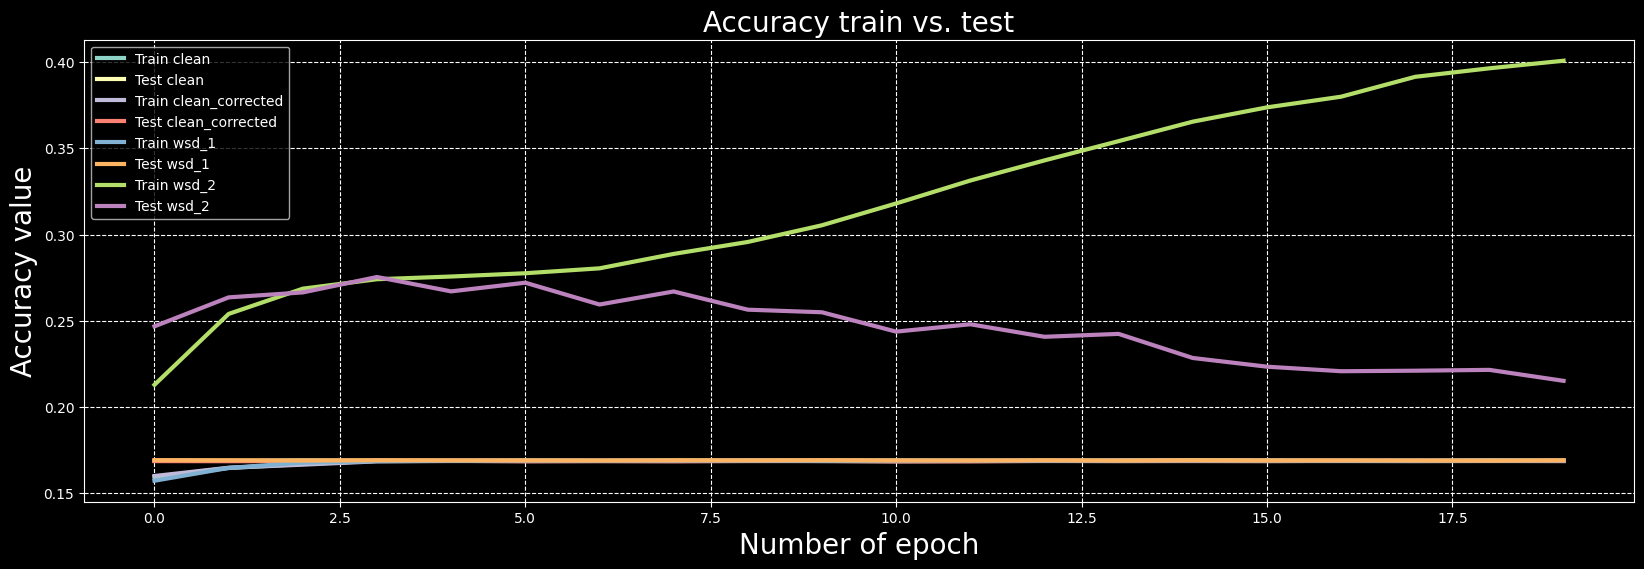

In [56]:
plt.style.use('dark_background')
plt.figure(figsize=(20, 6))

plt.plot(number_of_epochs, accuracies_train_clean, label=f'Train clean', linewidth=3)
plt.plot(number_of_epochs, accuracies_test_clean, label='Test clean', linewidth=3)

plt.plot(number_of_epochs, accuracies_train_clean_corrected, label=f'Train clean_corrected', linewidth=3)
plt.plot(number_of_epochs, accuracies_test_clean_corrected, label='Test clean_corrected', linewidth=3)

plt.plot(number_of_epochs, accuracies_train_wsd_1, label=f'Train wsd_1', linewidth=3)
plt.plot(number_of_epochs, accuracies_test_wsd_1, label='Test wsd_1', linewidth=3)

plt.plot(number_of_epochs, accuracies_train_wsd_2, label=f'Train wsd_2', linewidth=3)
plt.plot(number_of_epochs, accuracies_test_wsd_2, label='Test wsd_2', linewidth=3)


plt.xlabel('Number of epoch', fontsize=20)
plt.ylabel('Accuracy value', fontsize=20)
plt.title(f'Accuracy train vs. test', fontsize=20)

plt.legend(loc='upper left')
plt.grid(linestyle='--')

plt.show()

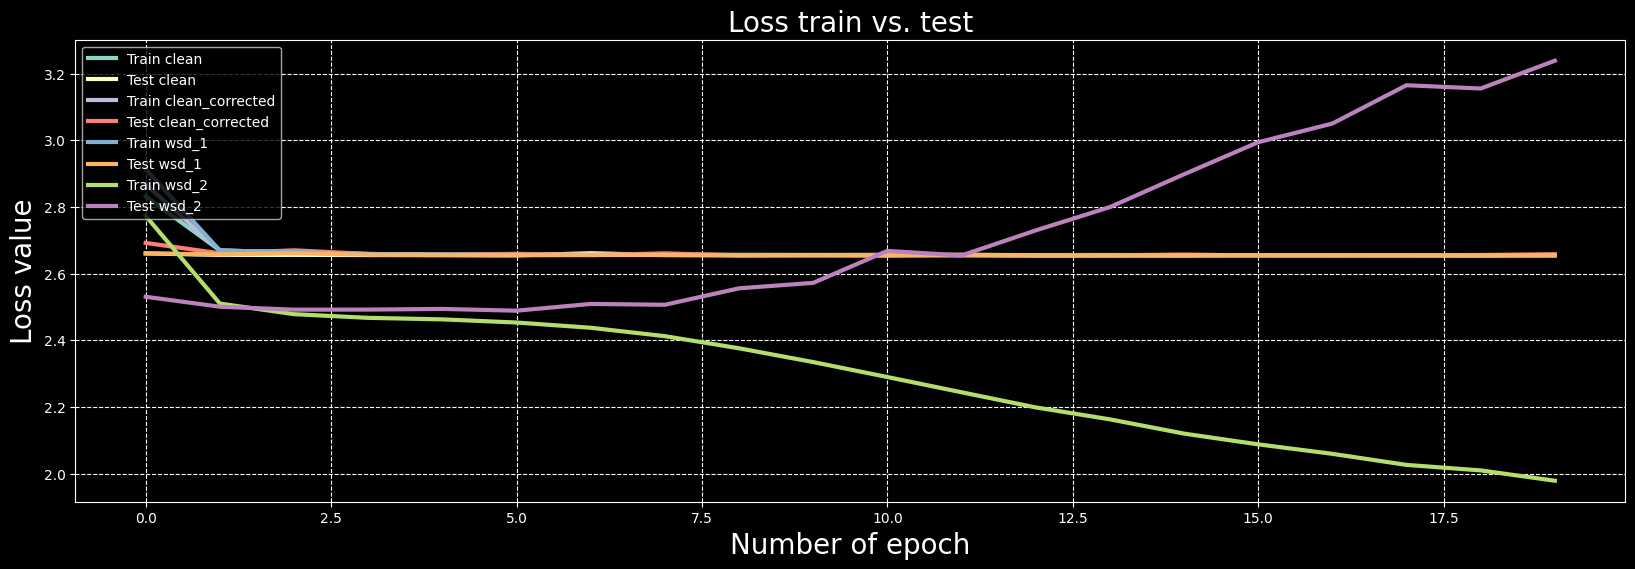

In [57]:
plt.style.use('dark_background')
plt.figure(figsize=(20, 6))

plt.plot(number_of_epochs, losses_train_clean, label=f'Train clean', linewidth=3)
plt.plot(number_of_epochs, losses_test_clean, label='Test clean', linewidth=3)

plt.plot(number_of_epochs, losses_train_clean_corrected, label=f'Train clean_corrected', linewidth=3)
plt.plot(number_of_epochs, losses_test_clean_corrected, label='Test clean_corrected', linewidth=3)

plt.plot(number_of_epochs, losses_train_wsd_1, label=f'Train wsd_1', linewidth=3)
plt.plot(number_of_epochs, losses_test_wsd_1, label='Test wsd_1', linewidth=3)

plt.plot(number_of_epochs, losses_train_wsd_2, label=f'Train wsd_2', linewidth=3)
plt.plot(number_of_epochs, losses_test_wsd_2, label='Test wsd_2', linewidth=3)


plt.xlabel('Number of epoch', fontsize=20)
plt.ylabel('Loss value', fontsize=20)
plt.title(f'Loss train vs. test', fontsize=20)

plt.legend(loc='upper left')
plt.grid(linestyle='--')

plt.show()